In [1]:
import os 
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import lognorm
import pandas as pd
import seaborn
import distfit
from distfit import distfit
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import configparser
import datetime
from datetime import timedelta
import math

#from sigfig import round as sig_dig


In [2]:

    
def self_grubbs(data_set,alpha=0.05,report=False):
    
    '''
    Grubbs Outlier test 
    Inputs:
        data_set: data set as list or array
        alpha: significance level of two sided test (one side: double alpha) as float
        report: bool if report is printed
         
    returns
        [0]: Value with maximal delta (most sus outlier) as float
        [1]: Test statistic of [0], G-value as float
        [2]: critical value of a t-distribution with N-2 df and significance of alpha/(2N) as float
        [3]: critical value Grubbs test, G_crit as float
        [4]: bool of outlier detection: True -> there is at least one outlier
        [5]: Test statistic value of a t-distribution  as float
        [6]: p-value of the test statistic as float
        [7]: position of potential outlier in list as int
    
    Ref. https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h1.htm
    
    H0:  there are no outliers in the data
    Ha:  the maximum value is an outlier
    
    For the two-sided test, the hypothesis of no outliers is rejected if
    G >  (N−1)/√N * √(tα/(2N),N−2)^2 /(N−2+(tα/(2N),N−2)^2)
    with tα/(2N),N−2 denoting the critical value of the t distribution with (N-2) degrees of freedom and a significance level of α/(2N).
    For one-sided tests, we use a significance level of level of α/N.
    
    Test Example:
    test_data_grubbs = [199.31, 199.53, 200.19, 200.82, 201.92, 201.95, 202.18, 245.57]
    
    Test statistic:  G = 2.4687 
    Significance level:  α = 0.05
    Critical value for an upper one-tailed test:  2.032          
    Critical region:  Reject H0 if G > 2.032
    
    
    Proof:
    
    self_grubbs(test_data_grubbs,alpha=0.1,report=True)
    
    The data set includes at least one outlier on alpha:0.1.
    The value 245.57, pos: 7, has a G-value of 2.469
    The p-value of the most suspicious data point is 3e-07
    The critical value is 2.032.

    -------------------------
    (245.57,
     2.46876461121245,
     3.5212227105092806,
     2.031652001549952,
     True,
     34.79705823086377,
     3.0026386820713584e-07)
    
    
    
    '''
    
    mean = np.mean(data_set)
    SD = np.std(data_set, ddof=1)
    abs_differences = [abs(x-mean) for x in data_set]
    max_delta = np.max(abs_differences)
    max_delta_value = data_set[np.argmax(abs_differences)]
    G_calc = max_delta/SD
    
    N = len(data_set)
    
    G_crit,t_dist = calc_G_crit(N,alpha)
    
    T_calc = np.sqrt((N*(N-2)*G_calc**2)/ ((N-1)**2 - N* G_calc**2 ))
    p_calc = stats.t.sf(T_calc, df=N-2)*2 * N
    
    outlier_detected = bool(G_calc>G_crit)
    
    if report:
        print('-------------------------')
        print()
        if outlier_detected:
                   
            print(f'The data set includes at least one outlier on alpha:{alpha}.')
            print(f'The value {round(max_delta_value,3)}, pos: {np.argmax(abs_differences)}, has a G-value of {round(G_calc,3)}')
            print(f'The p-value of the most suspicious data point is {round(p_calc,5)}')
            print(f'The critical value is {round(G_crit,3)}.')
     
        else:
            print(f'The data set includes no outlier on alpha:{alpha}.')
            print(f'The p-value of the most suspicious data point is {round(p_calc,3)}')
            print(f'The p-value belongs to: {round(max_delta_value,5)}, pos: {np.argmax(abs_differences)}')
            
        print()
        print('-------------------------')        
    
    return max_delta_value, G_calc,t_dist,G_crit, outlier_detected,T_calc,p_calc,np.argmax(abs_differences)


def calc_G_crit(N,alpha):
    
    '''
    Calculation of the critical value of the grubbs test
    Inputs:
        N: number of observations: as int
        alpha: alpha: significance level of two sided test (one side: double alpha) as float
    Returns:
        [0]: critical value Grubbs test, G_crit as float
        [1]: critical value of a t-distribution with N-2 df and significance of alpha/(2N) as float

    
    Ref. https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h1.htm
    
    H0:  there are no outliers in the data
    Ha:  the maximum value is an outlier
    
    For the two-sided test, the hypothesis of no outliers is rejected if
    G >  (N−1)/√N * √(tα/(2N),N−2)^2 /(N−2+(tα/(2N),N−2)^2)
    with tα/(2N),N−2 denoting the critical value of the t distribution with (N-2) degrees of freedom and a significance level of α/(2N).
    For one-sided tests, we use a significance level of level of α/N.
    
    Test Example:
    test_data_grubbs = [199.31, 199.53, 200.19, 200.82, 201.92, 201.95, 202.18, 245.57]
    
    

    Test statistic:  G = 2.4687 
    Significance level:  α = 0.05, 0.01 for two tail
    Critical value for an upper one-tailed test:  2.032          
    Critical region:  Reject H0 if G > 2.032 
    
    proof:
    calc_G_crit(len(test_data_grubbs),alpha=0.05)
    (2.031652001549952, 3.5212227105092806)
    
    '''
    t_dist = sc.stats.t.ppf(1-alpha/(2*N),N-2)
    G_crit = (N-1)/np.sqrt(N) * np.sqrt(t_dist**2/(N-2 + t_dist**2))
    return G_crit,t_dist

In [3]:
ms_ACE_total_data_DF = pd.read_excel('Summary_ms_ACE_data.xlsx')
analyte_list = list(ms_ACE_total_data_DF['analyte'].unique())
print(analyte_list)
Exclude_DP_list_in = []

clean_DF = ms_ACE_total_data_DF.drop(Exclude_DP_list_in,axis=0)

clean_DF = clean_DF[clean_DF['c'] !=20]

['CBZ', 'S-AML', 'R-AML', 'D-TRP', 'L-TRP', 'PRO', 'R-VER', 'S-VER']


In [4]:
print_it = False
Data_name = 'ms_ACE_Nov_2021_effective_mobility_outlier'

clean_DF_grouped = clean_DF
clean_DF_grouped['ANATYPE'] = clean_DF['analyst'] + clean_DF['sample type']
clean_DF_grouped['Outlier'] = False

clean_DF_grouped = clean_DF.groupby(['analyte','c','ANATYPE'])
list_of_group_keys_total = list(clean_DF_grouped.groups)
outlier_index_list = []

if print_it:
    print('Outlier test ms-ACE data')
    print(f'Date: {datetime.datetime.today()}')

with open(f'{Data_name}.txt', 'w') as f:
    f.write(f'-------------------------------------------------------- \n')
    f.write(f'-------------------------------------------------------- \n')
    f.write(f'Outlier test: ms-ACE \n')
    f.write(f'Date: {datetime.datetime.today()} \n')
    f.write(f' \n')
    
    
    for key_in in list_of_group_keys_total:

        outlier_bool = True
        update= False
        subset_in_t = clean_DF_grouped.get_group(key_in)
        subset_in = np.array(clean_DF_grouped.get_group(key_in)['mobility'])
        
        f.write(f'-------------------------------------------------------- \n')
        f.write(f'-------------------------------------------------------- \n')
        f.write(f'Outlier test: {key_in} \n')
        
        
        
        f.write(f' \n')
        f.write(f'{clean_DF_grouped.get_group(key_in)} \n')
        f.write(f' \n')
        if print_it:
            
            print('--------------------------------------------------------')


            print('--------------------------------------------------------')
            print(f'Outlier test: {key_in}')
            print()
            print(clean_DF_grouped.get_group(key_in))
            print()
        while outlier_bool:

            outlier_value, __, __,___, outlier_bool, __, p_out, outlier_pos = self_grubbs(np.array(subset_in),alpha=0.05,report=print_it)
            if outlier_bool:
                outlier_index_t = subset_in_t[subset_in_t['mobility']==outlier_value].index[0]
                clean_DF['Outlier'][outlier_index_t] = True
                subset_in = np.delete(subset_in,outlier_pos)
                f.write(f' \n')
                f.write(f'{outlier_value} removed, p-value= {p_out} \n')
                f.write(f' \n')
                
                f.write(f'new data set: \n')
                f.write(f' \n')
                f.write(f' {subset_in} \n')
                if print_it:
                    print()
                    print(f'{outlier_value} removed, p-value= {p_out}')
                    print()

                    print('new data set:')
                    print()
                    print(subset_in)
                update= True

        if update:
            f.write(f' \n')
            f.write(f'Updated Dataframe: \n')
            f.write(f'{clean_DF_grouped.get_group(key_in)} \n')
            
            f.write(f' \n')
            
            if print_it:
                print()
                print('Updated Dataframe:')
                print(clean_DF_grouped.get_group(key_in))
                print()
        
        f.write(f'-------------------------------------------------------- \n')
        f.write(f'-------------------------------------------------------- \n')
        f.write(f' \n')

    f.write(f' \n')
    f.write(f'-------------------------------------------------------- \n')
    f.write(f'-------------------------------------------------------- \n')
    
    summary_df = clean_DF[clean_DF['Outlier']==True]
    f.write(f' \n')
    f.write(f'Summary Outliers \n')
    f.write(f' \n')
    f.write(f'{summary_df} \n')
    f.write(f' \n')
    if print_it:
        print()
        print('--------------------------------------------------------')

        print('--------------------------------------------------------')
        print()
        print('Summary Outliers')
        print()
        print(summary_df)
        print()
        print('--------------------------------------------------------')

        print('--------------------------------------------------------')
    f.write(f'-------------------------------------------------------- \n')
    f.write(f'-------------------------------------------------------- \n')
    

clean_DF.to_csv(f'{Data_name}.csv')
clean_DF.to_pickle(f'{Data_name}.pkl')

In [5]:

# include sus Data point of CBZ
clean_DF['Outlier'][58] = False

analyte_i = 'S-VER'


clean_DF_grouped = clean_DF


clean_DF_grouped = clean_DF.groupby(['analyte','c','ANATYPE'])


clean_DF_analyte_total = clean_DF[clean_DF['analyte']==analyte_i]

clean_DF_analyte_outlier = clean_DF_analyte_total[clean_DF_analyte_total['Outlier']==True]
clean_DF_analyte = clean_DF_analyte_total[clean_DF_analyte_total['Outlier']==False]


clean_DF_analyte_gr = clean_DF_analyte.groupby(['c','ANATYPE'])
list_of_group_keys_t = list(clean_DF_analyte_gr['mobility'].groups)
mob_lists_t = [list(clean_DF_analyte_gr['mobility'].get_group(list_of_group_keys_t[a])) for a in range(len(list_of_group_keys_t))]


lev_stats_t, Lev_p_t = stats.levene(*mob_lists_t,center='median')


c_in_list = clean_DF_analyte['c'].unique() 

print('-------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------')
print()
print(f'Statistics analyte: {analyte_i}, version Nov 2021')
print()
print('-------------------------------------------------------------------------------------')
print()
print(datetime.datetime.today())
print()
print(f'Data set: Summary_ms_ACE_data.xlsx')
print()

print()
print('-------------------------------------------------------------------------------------')
print()
print('Grubbs Outlier test:')
print()
print(clean_DF_analyte_outlier)
print()
print('-------------------------------------------------------------------------------------')

for c_in in c_in_list:
    

    clean_DF_analyte_c = clean_DF_analyte[clean_DF_analyte['c'] == c_in]
    clean_DF_analyte_c_anatype = clean_DF_analyte_c.groupby('ANATYPE')
    
    
    list_of_group_keys = list(clean_DF_analyte_c_anatype['mobility'].groups)
    mob_lists = [list(clean_DF_analyte_c_anatype['mobility'].get_group(list_of_group_keys[a])) for a in range(len(list_of_group_keys))]
    try:
        lev_stats, Lev_p = stats.levene(*mob_lists,center='median')
    except:
        lev_stats, Lev_p = ['N too low','N too low']
        
    try:
        ANOVA_stats, ANOVA_p = stats.f_oneway(*mob_lists)
    except:
        ANOVA_stats, ANOVA_p = ['N too low','N too low']
    
    try:
        model = ols('mobility ~ ANATYPE', data=clean_DF_analyte_c).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
    except:
        anova_table = ['N too low']
    
    try:
        tukey = pairwise_tukeyhsd(endog=clean_DF_analyte_c['mobility'],
                              groups=clean_DF_analyte_c['ANATYPE'],
                              alpha=0.05)
    except:
        tukey =  ['N too low']


    print('-------------------------------------------------------------------------------------')
    print(f'analyte: {analyte_i}, c: {c_in}')
    print()
    print('raw statistics')
    print()
    print(clean_DF_analyte_c_anatype['mobility'].describe())
    print()
    print('-------------------------------------------------------------------------------------')
    print()
    print('Shapiro-Wilk')
    for key_in in list_of_group_keys:
        SW_R = stats.shapiro(clean_DF_analyte_c_anatype['mobility'].get_group(key_in))
        print(f'{key_in}: {SW_R}')
    
    print()
    print('Levene')
    print(f'Levene: {lev_stats, Lev_p}')
    print()
    print('One-way ANOVA')
    print(f'ANOVA: {ANOVA_stats, ANOVA_p}')
    print()
    print(anova_table)
    
    print()
    print('Tukey test')

    print(tukey)
    print('-------------------------------------------------------------------------------------')
    print()
    
print('Levene total')
print(f'{lev_stats_t, Lev_p_t}')
print()
print()
print('-------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

Statistics analyte: S-VER, version Nov 2021

-------------------------------------------------------------------------------------

2022-03-19 13:15:13.738172

Data set: Summary_ms_ACE_data.xlsx


-------------------------------------------------------------------------------------

Grubbs Outlier test:

Empty DataFrame
Columns: [analyte, analyst, sample type, c, mobility, ANATYPE, Outlier]
Index: []

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
analyte: S-VER, c: 0

raw statistics

         count       mean       std     min       25%      50%       75%  \
ANATYPE                                           

In [6]:
clean_DF['Outlier'][58] = False

analyte_i = 'CBZ'

clean_DF_no_outlier = clean_DF[clean_DF['Outlier']==False]

clean_DF_analyte_total_grouped = clean_DF_no_outlier.groupby(['analyte','c','analyst','sample type'])


In [7]:
clean_DF_no_outlier

,analyte,analyst,sample type,c,mobility,ANATYPE,Outlier
0,CBZ,GE,p,0,-0.085851,GEp,False
1,CBZ,GE,p,0,-0.130370,GEp,False
2,CBZ,GE,p,0,-0.095801,GEp,False
3,CBZ,GE,p,0,-0.120090,GEp,False
4,CBZ,GE,p,0,-0.115880,GEp,False
...,...,...,...,...,...,...,...
899,S-AML,GE,r,50,2.699900,GEr,False
900,S-AML,GE,r,50,2.746100,GEr,False
901,S-AML,GE,r,50,2.648400,GEr,False
902,S-AML,GE,r,50,2.662500,GEr,False


In [8]:
list_of_total_groups = list(clean_DF_analyte_total_grouped.groups)


Total_score_df = {'analyte':[], 'c':[], 'analyst':[],'sample type':[], 'mean':[], 'Var':[],'ln Var':[],'SD':[], 'CV':[],'n':[],'(n-1) s^2':[]}

# How to cope with lognormal distributions
# Analyzing data from a lognormal distribution is easy. Simply transform the data by taking the logarithm of each value. These logarithms are expected to have a Gaussian distribution, so can be analyzed by t tests, ANOVA, etc.





group_key_list = ['analyte','c','analyst','sample type']

for i in range(len(list_of_total_groups)):

    mobility_i = clean_DF_analyte_total_grouped.get_group(list_of_total_groups[i])['mobility']

    for key_i in range(len(group_key_list)):
        key = group_key_list[key_i]
        Total_score_df[key].append(list_of_total_groups[i][key_i])

    Total_score_df['mean'].append(np.mean(mobility_i))
    Total_score_df['Var'].append(np.var(mobility_i,ddof=1))
    Total_score_df['SD'].append(np.std(mobility_i,ddof=1))
    Total_score_df['CV'].append(100*np.std(mobility_i,ddof=1)/np.mean(mobility_i))
    Total_score_df['ln Var'].append(np.log(np.var(mobility_i,ddof=1)))
    
    Total_score_df['n'].append(len(mobility_i))
    Total_score_df['(n-1) s^2'].append((len(mobility_i)-1)*(np.var(mobility_i,ddof=1)))


Total_score_DF = pd.DataFrame(Total_score_df)



In [9]:
Total_score_DF

,analyte,c,analyst,sample type,mean,Var,ln Var,SD,CV,n,(n-1) s^2
0,CBZ,0,CZ,p,-0.177053,0.000787,-7.147502,0.028050,-15.842929,6,0.003934
1,CBZ,0,GE,p,-0.111695,0.000293,-8.133829,0.017130,-15.336509,6,0.001467
2,CBZ,0,IN,p,-0.146987,0.000632,-7.366138,0.025146,-17.107463,6,0.003162
3,CBZ,15,CZ,p,-0.849748,0.000596,-7.425902,0.024405,-2.872074,6,0.002978
4,CBZ,15,GE,p,-0.851718,0.002987,-5.813616,0.054650,-6.416428,6,0.014933
...,...,...,...,...,...,...,...,...,...,...,...
146,S-VER,90,GE,r,9.177567,0.003472,-5.662971,0.058925,0.642058,6,0.017361
147,S-VER,90,IN,r,8.410483,0.002545,-5.973703,0.050446,0.599799,6,0.012724
148,S-VER,110,CZ,r,8.418633,0.022573,-3.790992,0.150244,1.784658,6,0.112866
149,S-VER,110,GE,r,8.631967,0.002641,-5.936657,0.051389,0.595335,6,0.013204


In [10]:
group = 'analyte'
level1 = 'PRO'
group2 = None
level2 = None
group3 = None
level3 = None
group4 = None
level4 = None

DF_fiter  = clean_DF
DF_fiter = Total_score_DF

Total_score_DF_selected = DF_fiter[DF_fiter[group] == level1]

if group2:
    Total_score_DF_selected = Total_score_DF_selected[Total_score_DF_selected[group2] == level2]
    
    if group3:
        Total_score_DF_selected = Total_score_DF_selected[Total_score_DF_selected[group3] == level3]
    
        if group4:
            Total_score_DF_selected = Total_score_DF_selected[Total_score_DF_selected[group4] == level4]

Total_score_DF_selected.head(16)

,analyte,c,analyst,sample type,mean,Var,ln Var,SD,CV,n,(n-1) s^2
56,PRO,0,CZ,r,16.01120,0.000876,-7.039916,0.029601,0.184875,5,0.003505
57,PRO,15,CZ,r,15.77800,0.003432,-5.674729,0.058580,0.371276,6,0.017158
58,PRO,30,CZ,r,15.25850,0.004120,-5.491829,0.064190,0.420681,6,0.020602
59,PRO,50,CZ,r,14.57550,0.000967,-6.941209,0.031098,0.213360,6,0.004836
60,PRO,70,CZ,r,13.76250,0.007358,-4.911981,0.085778,0.623275,6,0.036790
61,PRO,90,CZ,r,13.50250,0.006514,-5.033878,0.080706,0.597713,6,0.032568
62,PRO,110,CZ,r,12.03216,0.007058,-4.953533,0.084014,0.698249,5,0.028234


In [11]:
Total_score_DF_selected['Var'].describe()

count    7.000000
mean     0.004332
std      0.002753
min      0.000876
25%      0.002199
50%      0.004120
75%      0.006786
max      0.007358
Name: Var, dtype: float64

In [12]:
total_vars = Total_score_DF['Var']

total_Var_boxcox,KD_lambda_box_cox = stats.boxcox(total_vars,lmbda=None)
print(KD_lambda_box_cox)

0.035082392899151084


0.035082392899151084


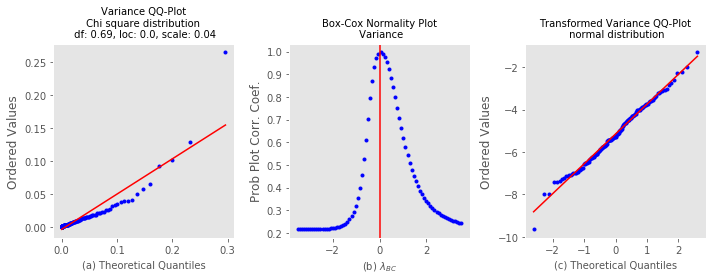

In [13]:
df, loc, scale = sc.stats.chi2.fit(total_vars)
_, maxlog_KD = stats.boxcox(total_vars)

plt.style.use('ggplot')

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(131)

prob = stats.probplot(total_vars, dist="chi2",sparams=(df, loc, scale), plot=ax)

ax.set_xlabel('')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_color('blue')
ax.set_title(f'Variance QQ-Plot\n Chi square distribution \n df: {round(df,2)}, loc: {round(loc,2)}, scale: {round(scale,2)}',size='10')
ax.set_xlabel('(a) Theoretical Quantiles',size='10')
plt.grid()


ax1 = fig.add_subplot(132)

prob = stats.boxcox_normplot(total_vars, -3.5, 3.5, plot=ax1)
ax1.set_title('Box-Cox Normality Plot\n Variance',size='10')
ax1.axvline(maxlog_KD, color='r')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_color('blue')
ax1.set_xlabel('(b) $\lambda_{BC}$',size='10')
plt.grid()

ax2 = fig.add_subplot(133)

total_Var_boxcox, lambda_box_cox = stats.boxcox(total_vars,lmbda=None)
prob = stats.probplot(total_Var_boxcox, dist=stats.norm, plot=ax2)
ax2.set_title('Transformed Variance QQ-Plot\n normal distribution',size='10')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_color('blue')
ax2.set_xlabel('(c) Theoretical Quantiles',size='10')
plt.grid()

plt.tight_layout()

#plt.savefig('Box_Cox_Variacnes_chi.pdf')

print(lambda_box_cox)

In [14]:
Total_score_DF['Var Box Cox'] = total_Var_boxcox


self_grubbs(total_Var_boxcox,alpha=0.05,report=True)


Total_score_DF

-------------------------

The data set includes no outlier on alpha:0.05.
The p-value of the most suspicious data point is 0.162
The p-value belongs to: -9.65001, pos: 23

-------------------------


,analyte,c,analyst,sample type,mean,Var,ln Var,SD,CV,n,(n-1) s^2,Var Box Cox
0,CBZ,0,CZ,p,-0.177053,0.000787,-7.147502,0.028050,-15.842929,6,0.003934,-6.321811
1,CBZ,0,GE,p,-0.111695,0.000293,-8.133829,0.017130,-15.336509,6,0.001467,-7.076257
2,CBZ,0,IN,p,-0.146987,0.000632,-7.366138,0.025146,-17.107463,6,0.003162,-6.491305
3,CBZ,15,CZ,p,-0.849748,0.000596,-7.425902,0.024405,-2.872074,6,0.002978,-6.537411
4,CBZ,15,GE,p,-0.851718,0.002987,-5.813616,0.054650,-6.416428,6,0.014933,-5.259088
...,...,...,...,...,...,...,...,...,...,...,...,...
146,S-VER,90,GE,r,9.177567,0.003472,-5.662971,0.058925,0.642058,6,0.017361,-5.135912
147,S-VER,90,IN,r,8.410483,0.002545,-5.973703,0.050446,0.599799,6,0.012724,-5.389272
148,S-VER,110,CZ,r,8.418633,0.022573,-3.790992,0.150244,1.784658,6,0.112866,-3.549710
149,S-VER,110,GE,r,8.631967,0.002641,-5.936657,0.051389,0.595335,6,0.013204,-5.359212


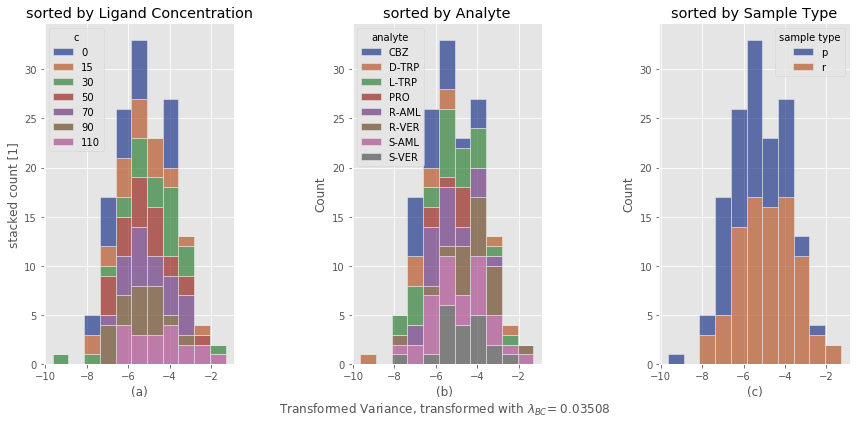

In [15]:

names = ['c','analyte','sample type']

kde_dict = {}

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)

seaborn.histplot(data=Total_score_DF, x='Var Box Cox', hue='c',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Ligand Concentration')
plt.ylabel('stacked count [1]')
plt.xlabel('(a)')


plt.subplot(1,3,2)

seaborn.histplot(data=Total_score_DF, x='Var Box Cox', hue='analyte',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Analyte')

BC ='{BC}'
plt.xlabel(f'(b) \nTransformed Variance, transformed with $\lambda_{BC}$= {round(lambda_box_cox,5)}  ')


plt.subplot(1,3,3)

seaborn.histplot(data=Total_score_DF, x='Var Box Cox', hue='sample type',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Sample Type')

plt.xlabel('(c)')

#plt.suptitle('Distribution of the Transformed Variances')
plt.tight_layout()

#plt.savefig('Distribution_transformed_Var_sorted.pdf')

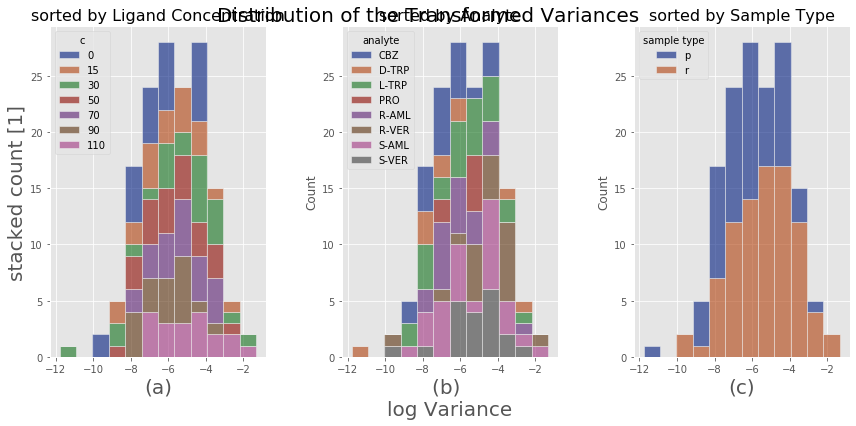

In [16]:
names = ['c','analyte','sample type']

kde_dict = {}

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)

seaborn.histplot(data=Total_score_DF, x='ln Var', hue='c',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Ligand Concentration',size=16)
plt.ylabel('stacked count [1]',size=20)
plt.xlabel('(a)',size=20)


plt.subplot(1,3,2)

seaborn.histplot(data=Total_score_DF, x='ln Var', hue='analyte',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Analyte',size=16)

plt.xlabel('(b) \nlog Variance',size=20)


plt.subplot(1,3,3)

seaborn.histplot(data=Total_score_DF, x='ln Var', hue='sample type',
            kde=False,kde_kws=kde_dict,palette = 'dark',common_norm = True, alpha=.6,
            bins='auto',multiple="stack",label=names) 

plt.title('sorted by Sample Type',size=16)

plt.xlabel('(c)',size=20)

plt.suptitle('Distribution of the Transformed Variances',size = 20)
plt.tight_layout()

#plt.savefig('Distribution_ln_transformed_Var_sorted.pdf')

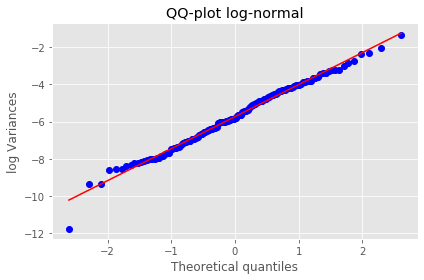

In [17]:
data = Total_score_DF['ln Var']

sc.stats.probplot(data, dist="norm", plot=plt)

plt.title('QQ-plot log-normal')
plt.ylabel('log Variances')
#plt.savefig('QQ_plot_ln_variance.pdf')
plt.tight_layout()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm   ] [0.0 sec] [RSS: 9990.0763099] [loc=0.012 scale=0.027]
[distfit] >[gamma  ] [0.04 sec] [RSS: 8007.6695440] [loc=0.000 scale=1.225]
[distfit] >[lognorm] [0.02 sec] [RSS: 559.3265542] [loc=-0.000 scale=0.003]
[distfit] >[chi    ] [0.04 sec] [RSS: 4471.9044262] [loc=0.000 scale=0.050]
[distfit] >[chi2   ] [0.04 sec] [RSS: 4843.4155977] [loc=0.000 scale=0.043]
[distfit] >[expon  ] [0.0 sec] [RSS: 2475.0211720] [loc=0.000 scale=0.012]
[distfit] >[beta   ] [0.05 sec] [RSS: 1374.2843923] [loc=0.000 scale=0.336]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
     distr    score  LLE          loc       scale  \
0  lognorm  559.327  NaN -1.28355e-05  0.00330681   
1     beta  1374.28  NaN  7.64667e-06    0.336061   
2    expon  2475.02  NaN  7.64667e-06   0.0118391   
3      chi   4471.9  NaN  7.64667e-06    0.049727   
4     chi2  4843.42  NaN  7.64667e-06   0.0425526   
5    gamma  8007.67  NaN  7.64667e-06     

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c08915788>)

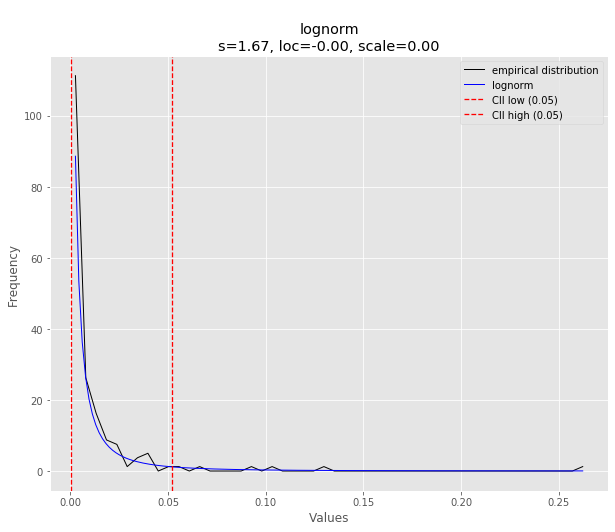

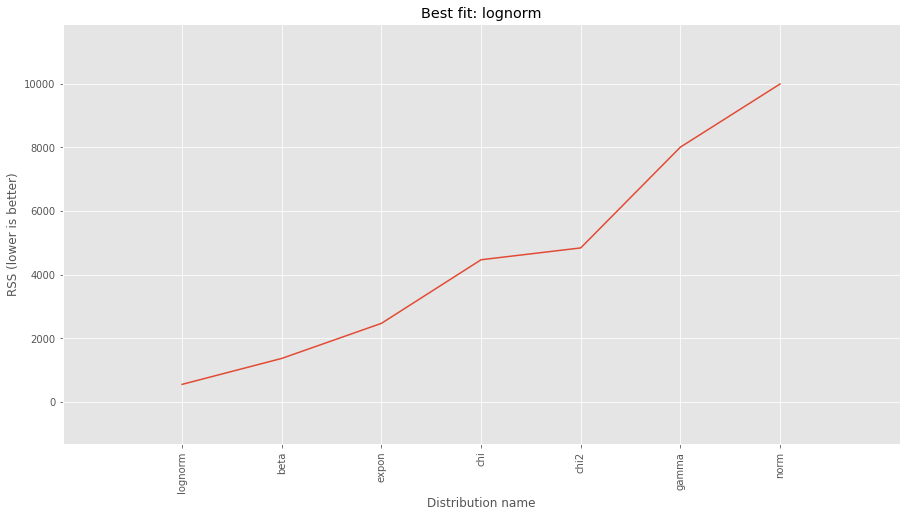

In [18]:
dist_names = ['norm','gamma','lognorm','chi','chi2','expon','beta']

#dist_names = ['chi2']
data = Total_score_DF['Var']

red_n = None
data_red = data
if red_n:
    for i in range(red_n):

        data_red = data_red.drop(data_red.idxmax())

dist = distfit(distr=dist_names,todf=True,method='parametric')
dist.fit_transform(data_red)
dist.plot()
print(dist.summary)
dist.plot_summary()

-5.730130114100726 1.7088481364456485
0.013981096141971794
0.003429400879294598
0.05856108673252741


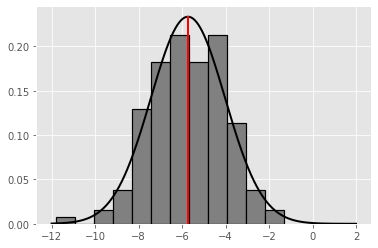

In [19]:
data = Total_score_DF['ln Var']
alpha_in = 0.95

loc, scale = stats.norm.fit(data)

x_list = np.linspace(-12,2,10000)

PDF_ln_var = [stats.norm.pdf(x,loc, scale) for x in x_list]


print(loc,scale)

print(np.exp(loc+(scale**2/2)))

print(np.exp(2*loc+scale**2) * (np.exp(scale**2)-1) )

print(np.exp(loc+(scale**2/2))* np.sqrt((np.exp(scale**2)-1)))

plt.hist(data,density=True,bins='auto',color='gray',edgecolor='black', linewidth=1.2)
plt.plot(x_list,PDF_ln_var,'k-',linewidth=2)
plt.plot([loc,loc],[0,np.max(PDF_ln_var)],'r-',linewidth=2)

1.7088481364456485 0.0 0.003246654770561144
0.01398109614716552

expressed as Var
0.01398109614197179
0.003246654770561144
0.0034294008792945963 0.003246654770561144
(0.0001139887365570028, 0.09247200659984743)

expressed as SD

10.676550779957111 304.0921021661816
118.24168529741019
56.97942409818779
56.97942409818779


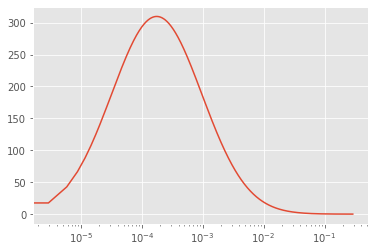

In [20]:
data = Total_score_DF['Var']
alpha_in = 0.95

shape, loc, scale = stats.lognorm.fit(data, floc=0)

print(shape, loc, scale)

expect = stats.lognorm.expect(func=None, args=(shape,), loc=loc, scale=scale, lb=None, ub=None, conditional=False)
print(expect)
mean = stats.lognorm.mean(shape, loc=loc, scale=scale)

Var = stats.lognorm.var(shape, loc=loc, scale=scale)
SD = stats.lognorm.std(shape, loc=loc, scale=scale)
median = SD = stats.lognorm.median(shape, loc=loc, scale=scale)
CI = stats.lognorm.interval(alpha_in,shape, loc=loc, scale=scale)

print()
print('expressed as Var')
print(mean)
print(median)
print(Var,SD)
print(CI)
print()
print('expressed as SD')
print()
print(np.sqrt(CI[0])*10**3,np.sqrt(CI[1])*10**3)
print(np.sqrt(mean)*10**3)
print(np.sqrt(median)*10**3)
print(np.sqrt(SD)*10**3)


x_list = np.linspace(0,1.1*np.max(data),100000)

PDF_log_var = [stats.lognorm.pdf(x,shape, loc, scale) for x in x_list]


plt.plot(x_list,PDF_log_var,'-')
plt.xscale('log')

In [21]:
tukey = pairwise_tukeyhsd(endog=Total_score_DF['ln Var'],
                          groups=Total_score_DF['analyte'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   CBZ  D-TRP  -0.1624    0.9 -2.0758  1.751  False
   CBZ  L-TRP   0.6763 0.8334 -0.7979 2.1504  False
   CBZ    PRO   0.9167    0.9 -1.2568 3.0902  False
   CBZ  R-AML   0.5912    0.9 -0.9647 2.1472  False
   CBZ  R-VER   2.0531  0.002  0.4972 3.6091   True
   CBZ  S-AML   1.2234 0.1583 -0.2143  2.661  False
   CBZ  S-VER   1.4104 0.1062 -0.1456 2.9663  False
 D-TRP  L-TRP   0.8387 0.8491 -1.0247  2.702  False
 D-TRP    PRO   1.0791 0.8679 -1.3751 3.5333  False
 D-TRP  R-AML   0.7536    0.9 -1.1751 2.6824  False
 D-TRP  R-VER   2.2155 0.0126  0.2868 4.1443   True
 D-TRP  S-AML   1.3858 0.2884 -0.4489 3.2204  False
 D-TRP  S-VER   1.5728 0.2003  -0.356 3.5015  False
 L-TRP    PRO   0.2405    0.9 -1.8891   2.37  False
 L-TRP  R-AML   -0.085    0.9  -1.579  1.409  False
 L-TRP  R-VER   1.3769 0.0944 -0.1171 2.8709  False
 L-TRP  S-AM

In [22]:
Total_score_DF_rm = Total_score_DF.rename(columns={'sample type': 'sample_type', 'ln Var': 'lnVar'})

mod = ols('lnVar ~ sample_type',
                data=Total_score_DF_rm).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                 sum_sq     df          F    PR(>F)
sample_type   29.361910    1.0  10.629519  0.001379
Residual     411.582545  149.0        NaN       NaN


In [23]:
tukey = pairwise_tukeyhsd(endog=Total_score_DF['ln Var'],
                          groups=Total_score_DF['c'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0     15   0.4752    0.9 -1.0238 1.9742  False
     0     30   1.1343 0.2282 -0.3094  2.578  False
     0     50   0.7552 0.6799 -0.6884 2.1989  False
     0     70   1.1815 0.1982 -0.2791 2.6422  False
     0     90   0.4554    0.9 -1.0654 1.9762  False
     0    110   1.6194 0.0288  0.0986 3.1401   True
    15     30   0.6591 0.8391 -0.8686 2.1868  False
    15     50     0.28    0.9 -1.2477 1.8077  False
    15     70   0.7063 0.7938 -0.8374 2.2501  False
    15     90  -0.0198    0.9 -1.6206 1.5809  False
    15    110   1.1441 0.3367 -0.4566 2.7449  False
    30     50  -0.3791    0.9 -1.8525 1.0944  False
    30     70   0.0472    0.9 -1.4429 1.5373  False
    30     90  -0.6789 0.8272  -2.228 0.8702  False
    30    110   0.4851    0.9  -1.064 2.0341  False
    50     70   0.4263    0.9 -1.0638 1.9164  False
    50     9

In [24]:
Total_score_DF_rm = Total_score_DF.rename(columns={'sample type': 'sample_type', 'ln Var': 'lnVar'})

mod = ols('lnVar ~ c',
                data=Total_score_DF_rm).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

              sum_sq     df        F   PR(>F)
c          17.950256    1.0  6.32299  0.01298
Residual  422.994199  149.0      NaN      NaN


In [25]:
tukey = pairwise_tukeyhsd(endog=Total_score_DF['ln Var'],
                          groups=Total_score_DF['sample type'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     p      r   0.8943 0.0014 0.3523 1.4363   True
--------------------------------------------------


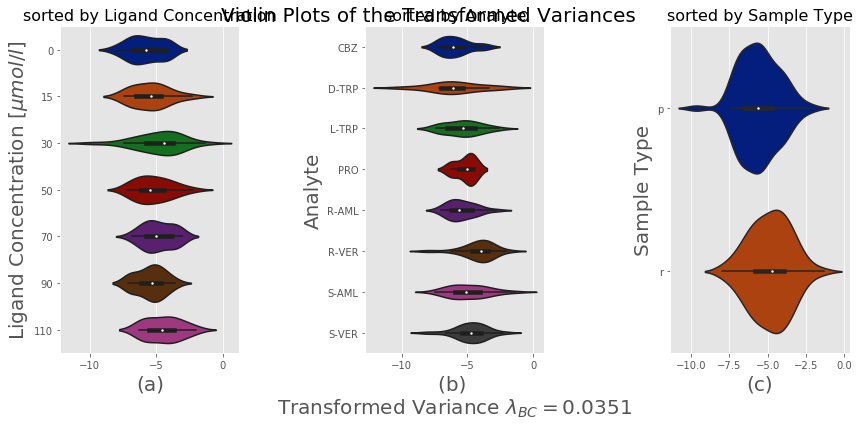

In [26]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)

seaborn.violinplot( x='Var Box Cox', y='c',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)

plt.title('sorted by Ligand Concentration',size=16)
plt.ylabel('Ligand Concentration [$\mu mol/l$]',size=20)
plt.xlabel('(a)',size=20)


plt.subplot(1,3,2)

seaborn.violinplot( x='Var Box Cox', y='analyte',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)

plt.title('sorted by Analyte',size=16)

plt.xlabel('(b) \nTransformed Variance $\lambda_{BC}=0.0351$',size=20)
plt.ylabel('Analyte',size=20)

plt.subplot(1,3,3)

seaborn.violinplot( x='Var Box Cox', y='sample type',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)


plt.title('sorted by Sample Type',size=16)

plt.xlabel('(c)',size=20)
plt.ylabel('Sample Type',size=20)


plt.suptitle('Violin Plots of the Transformed Variances',size = 20)

plt.tight_layout()

#plt.savefig('violines_Variances_trans_2.pdf')

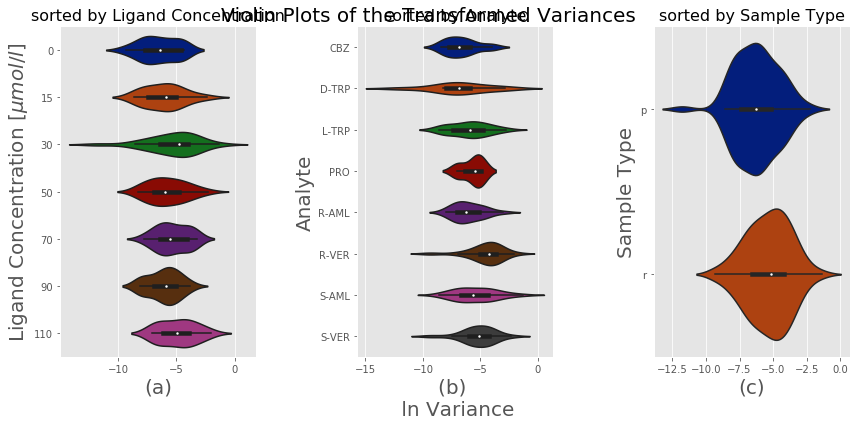

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)

seaborn.violinplot( x='ln Var', y='c',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)

plt.title('sorted by Ligand Concentration',size=16)
plt.ylabel('Ligand Concentration [$\mu mol/l$]',size=20)
plt.xlabel('(a)',size=20)


plt.subplot(1,3,2)

seaborn.violinplot( x='ln Var', y='analyte',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)

plt.title('sorted by Analyte',size=16)

plt.xlabel('(b) \n ln Variance',size=20)
plt.ylabel('Analyte',size=20)

plt.subplot(1,3,3)

seaborn.violinplot( x='ln Var', y='sample type',data=Total_score_DF, order=None, hue_order=None,
                  bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100,
                  width=0.8, inner='box', split=False,
                  dodge=True, orient='h', linewidth=None, color=None, palette='dark', saturation=0.95, ax=None)


plt.title('sorted by Sample Type',size=16)

plt.xlabel('(c)',size=20)
plt.ylabel('Sample Type',size=20)


plt.suptitle('Violin Plots of the Transformed Variances',size = 20)

plt.tight_layout()

#plt.savefig('violines_Variances_ln_trans.pdf')

0.009385724806288884 -6.195065356160599 0.20176386333135551 0.012979998589740504 0.0037325579558462373


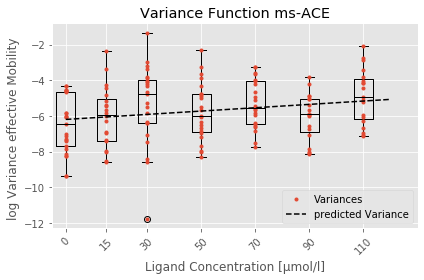

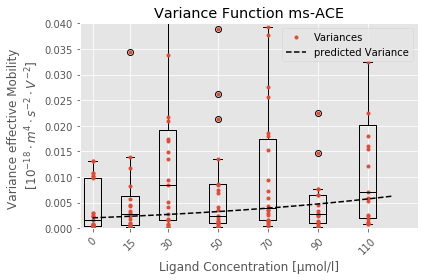

In [28]:
pos_in = [0,15,30,50,70,90,110]

c_data = Total_score_DF['c']
Variance_data = Total_score_DF['ln Var']

slope, intercept, r_value, p_value, std_err = stats.linregress(c_data,Variance_data)

print(slope, intercept, r_value, p_value, std_err)

c_list_plot = np.linspace(0,120,121)
Var_list_plot = [intercept+slope *c for c in c_list_plot]






Total_score_DF.boxplot(column= 'ln Var',by='c',rot=45,positions=pos_in,color='k',notch=False,figsize=(6,4), widths=7, patch_artist=False)


plt.plot(c_data, Variance_data,'.',label='Variances')
plt.plot(c_list_plot, Var_list_plot,'k--',label = 'predicted Variance')


plt.xlabel('Ligand Concentration [µmol/l]')
plt.ylabel('log Variance effective Mobility ')
plt.title('Variance Function ms-ACE')
plt.xlim([-5,130])
plt.suptitle('')
plt.legend()
plt.tight_layout()
#plt.savefig('Var_func_01.pdf')

Total_score_DF.boxplot(column= 'Var',by='c',rot=45,positions=pos_in,color='k',notch=False,figsize=(6,4), widths=7, patch_artist=False)

c_data = Total_score_DF['c']
Variance_data_lin = Total_score_DF['Var']
var_back = [np.exp(v) for v in Var_list_plot]

plt.plot(c_data, Variance_data_lin,'.',label='Variances')
plt.plot(c_list_plot, var_back,'k--',label = 'predicted Variance')


plt.xlabel('Ligand Concentration [µmol/l]')
plt.ylabel('Variance effective Mobility \n [$10^{-18} \cdot m^4 \cdot s^{-2} \cdot V^{-2}]$')
plt.title('Variance Function ms-ACE')
plt.xlim([-5,130])
plt.ylim(0,0.04)
plt.suptitle('')
plt.legend()
plt.tight_layout()
#plt.savefig('Var_func_02.pdf')

0.009385724806288884 -6.195065356160599 0.20176386333135551 0.012979998589740504 0.0037325579558462373


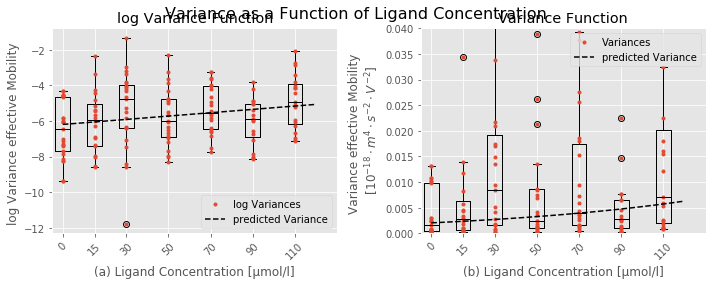

In [29]:
pos_in = [0,15,30,50,70,90,110]

c_data = Total_score_DF['c']
Variance_data = Total_score_DF['ln Var']

slope, intercept, r_value, p_value, std_err = stats.linregress(c_data,Variance_data)

print(slope, intercept, r_value, p_value, std_err)

c_list_plot = np.linspace(0,120,121)
Var_list_plot = [intercept+slope *c for c in c_list_plot]




figure, axes = plt.subplots(1, 2,figsize=(10,4))


Total_score_DF.boxplot(column= 'ln Var',by='c',rot=45,positions=pos_in,color='k',notch=False,figsize=(6,4), widths=7, patch_artist=False,ax=axes[0])



axes[0].plot(c_data, Variance_data,'.',label='log Variances')
axes[0].plot(c_list_plot, Var_list_plot,'k--',label = 'predicted Variance')



axes[0].set_xlabel('(a) Ligand Concentration [µmol/l]')
axes[0].set_ylabel('log Variance effective Mobility ')
axes[0].set_title('log Variance Function')
axes[0].set_xlim([-5,130])
axes[0].legend()

#plt.savefig('Var_func_01.pdf')

#Fig_B = plt.figure()



Total_score_DF.boxplot(column= 'Var',by='c',rot=45,positions=pos_in,color='k',notch=False,figsize=(6,4), widths=7, patch_artist=False,ax=axes[1])

c_data = Total_score_DF['c']
Variance_data_lin = Total_score_DF['Var']
var_back = [np.exp(v) for v in Var_list_plot]

axes[1].plot(c_data, Variance_data_lin,'.',label='Variances')
axes[1].plot(c_list_plot, var_back,'k--',label = 'predicted Variance')




axes[1].set_xlabel('(b) Ligand Concentration [µmol/l]')
axes[1].set_ylabel('Variance effective Mobility \n [$10^{-18} \cdot m^4 \cdot s^{-2} \cdot V^{-2}]$')
axes[1].set_title('Variance Function')
axes[1].set_xlim([-5,130])
axes[1].set_ylim(0,0.04)

axes[1].legend()

plt.suptitle('Variance as a Function of Ligand Concentration',size='16')
plt.tight_layout()
#plt.savefig('Var_func_merged.pdf')